Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
          Date         Open         High  ...       EMA 12       EMA 26      MACD
0   2000-01-03  1469.250000  1478.000000  ...  1455.219971  1455.219971  0.000000
1   2000-01-04  1455.219971  1455.219971  ...  1424.995011  1426.246932 -1.251921
2   2000-01-05  1399.420044  1413.270020  ...  1416.062980  1417.574761 -1.511781
3   2000-01-06  1402.109985  1411.900024  ...  1412.081540  1413.626082 -1.544542
4   2000-01-07  1403.449951  1441.469971  ...  1420.066271  1420.083194 -0.016923
5   2000-01-10  1441.469971  1464.359985  ...  1429.188936  1427.597507  1.591430
6   2000-01-11  1457.599976  1458.660034  ...  1431.280069  1429.547140  1.732930
7   2000-01-12  1438.560059  1442.599976  ...  1431.482479  1429.982637  1.499842
8   2000-01-13  1432.250000  1454.199951  ...  1435.082607  1432.902227  2.180380
9   2000-01-14  1449.680054  1473.000000  ...  1440

Text(0, 0.5, 'USD')

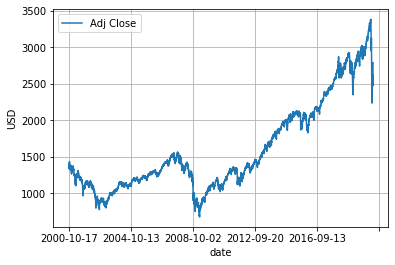

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import math
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale
from google.colab import drive
drive.mount('/content/drive')
# Quick disclaimer. I don't recommend you run this code locally as it will
# Take a lot of your computational resources and time to train. 
# If you would like to run this code, please run it on Google Colab with a GPU
  # Edit -> Notebook Settings -> GPU
# The purpose of this code is to show what I have done to train a model that makes stock market predictions
url = '/content/drive/My Drive/COMP3900 Data/^GSPC.csv'
dataset = pd.read_csv(url)

# Creating additional techincal analysis features to help predictions
# MA is moving average over x number of previous days
# EMA is exponential moving average over x number of previous days
# MACD is moving average convergence divergence
def get_technical_analysis(dataset):
  dataset['MA 7'] = dataset['Close'].rolling(window=7).mean()
  dataset['MA 20'] = dataset['Close'].rolling(window=20).mean()
  dataset['MA 50'] = dataset['Close'].rolling(window=50).mean()
  dataset['MA 200'] = dataset['Close'].rolling(window=200).mean()
  dataset['EMA 20'] = dataset['Close'].ewm(span=20).mean()
  dataset['EMA 50'] = dataset['Close'].ewm(span=50).mean()
  dataset['EMA 200'] = dataset['Close'].ewm(span=200).mean()
  dataset['EMA 12'] = dataset['Close'].ewm(span=12).mean()
  dataset['EMA 26'] = dataset['Close'].ewm(span=26).mean()
  dataset['MACD'] = dataset['EMA 12'] - dataset['EMA 26']

get_technical_analysis(dataset)
print(dataset.head(20))
include = ['Date', 'Adj Close', 'Volume', 
           'MA 7', 'MA 20', 'MA 50', 'MA 200', 
           'EMA 12', 'EMA 20', 'EMA 26', 'EMA 50', 'EMA 200', 'MACD']
features = ['Adj Close', 'Volume', 'MA 7', 'MA 20', 'MA 50', 'MA 200', 
           'EMA 12', 'EMA 20', 'EMA 26', 'EMA 50', 'EMA 200', 'MACD']
print(dataset.shape)
dataset = dataset[200:]
print(dataset.shape)
# Splitting the data into different parts for model training and testing
train_cut = math.ceil(dataset.shape[0] * 0.6)
train = dataset[:train_cut][include]
val_cut = math.ceil(dataset.shape[0] * 0.8)
val = dataset[train_cut:val_cut][include]
test = dataset[val_cut:][include]
ax = dataset.plot(x='Date', y='Adj Close', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [0]:
# This function is to split data into 
# x values (input values to make predictions),and y values (correct output)
def get_xy(data, lags, num_predictions):
  x = []
  y = []
  for i in range(lags, len(data) - num_predictions):
    x.append(np.array(data[i-lags:i]))
    y.append(np.array(data[i:i+num_predictions]))
  x = np.array(x)
  y = np.array(y)[:,:,0]
  y = y.reshape(y.shape + (1,))
  return x, y

# Function for testing accuracy. MAPE (Mean absolute percentage error) is 
# a really common way to measure accuracy, where the lower the MAPE value, the better
def get_mape(y_true, y_pred): 
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [0]:
print(train.head(5))
train_adj=train[features]
forecasts = 20
lags = 30
feature_sets = len(features)
scalers = [MinMaxScaler() for a in range(len(features))]
print(train_adj)
for a, feature in zip(range(len(features)), features):
  train_adj.loc[:, feature] = scalers[a].fit_transform(np.array(train[feature]).reshape(-1,1))
  # train_adj = train_adj.assign(train_adj[feature]=scalers[a].fit_transform(np.array(train[feature]).reshape(-1,1)))
  # train_adj.loc[:, feature] = scale(np.array(train[feature]).reshape(-1,1))
print(train_adj)
# scaler = StandardScaler()
# close_scaler = MinMaxScaler()
# volume_scaler = MinMaxScaler()
# train_adj = close_scaler.fit_transform(np.array(train['Adj Close']).reshape(-1,1))
# train_adj = np.concatenate((train_adj,volume_scaler.fit_transform(np.array(train['Volume']).reshape(-1,1))),axis=1)
print(train_adj.shape)
train_x, train_y = get_xy(train_adj, lags, forecasts)
print(train_x.shape)
print(train_y.shape)
model = tf.keras.Sequential()
# model.add(tf.compat.v1.keras.layers.CuDNNLSTM(units=50))
# model.add(layers.Dense(30, ))
# model.add(tf.compat.v1.keras.layers.CuDNNGRU(units=500,input_shape=(lags,1)))
# model.add(layers.Dropout(0.5))
# THIS IS ANOTHER VERSION
# model.add(tf.compat.v1.keras.layers.LSTM(units=250,input_shape=(lags,feature_sets),return_sequences=True))
# # model.add(layers.Dropout(0.25))
# model.add(tf.compat.v1.keras.layers.LSTM(units=100,return_sequences=True))
# # model.add(layers.Dropout(0.25))
# model.add(tf.compat.v1.keras.layers.LSTM(units=100))
model.add(tf.keras.layers.LSTM(units=250,input_shape=(lags,feature_sets),return_sequences=True))
model.add(layers.Dropout(0.25))
model.add(tf.keras.layers.LSTM(units=100,return_sequences=True))
# model.add(layers.Dropout(0.25))
model.add(tf.keras.layers.LSTM(units=100))
model.add(tf.keras.layers.Dense(128,activation='tanh'))
model.add(tf.keras.layers.Dense(128,activation='tanh'))
# model.add(layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(64,activation='tanh'))
model.add(tf.keras.layers.Dense(64,activation='tanh'))
# model.add(layers.Dropout(0.50))
model.add(layers.Dense(forecasts))
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])
# model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])
# model.compile(loss='mean_squared_error', metrics=['accuracy'])
history=model.fit(train_x.reshape(train_x.shape[0], train_x.shape[1], -1), train_y.reshape(train_y.shape[0], -1), epochs=100, verbose=2)
model.summary()

            Date    Adj Close      Volume  ...       EMA 50      EMA 200       MACD
200   2000-10-17  1349.969971  1161500000  ...  1439.125751  1450.014889 -29.464998
201   2000-10-18  1342.130005  1441700000  ...  1435.320820  1448.777228 -30.913004
202   2000-10-19  1388.760010  1297900000  ...  1433.494363  1448.089753 -27.975424
203   2000-10-20  1396.930054  1177400000  ...  1432.060059  1447.504619 -24.703353
204   2000-10-23  1395.780029  1046800000  ...  1430.636922  1446.913901 -21.949984
...          ...          ...         ...  ...          ...          ...        ...
3135  2012-06-19  1357.979980  3815350000  ...  1338.861621  1314.835342  -0.348208
3136  2012-06-20  1355.689941  3695700000  ...  1339.521556  1315.241855   1.798794
3137  2012-06-21  1325.510010  4094470000  ...  1338.972083  1315.344026   1.052902
3138  2012-06-22  1335.020020  5271490000  ...  1338.817100  1315.539807   1.215148
3139  2012-06-25  1313.719971  3501820000  ...  1337.832899  1315.521699  -0

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

(2890, 30, 12)
(2890, 20, 1)
Epoch 1/100
91/91 - 1s - loss: 0.0805 - accuracy: 0.0533
Epoch 2/100
91/91 - 1s - loss: 0.0494 - accuracy: 0.0682
Epoch 3/100
91/91 - 1s - loss: 0.0438 - accuracy: 0.0619
Epoch 4/100
91/91 - 1s - loss: 0.0433 - accuracy: 0.0657
Epoch 5/100
91/91 - 1s - loss: 0.0404 - accuracy: 0.0678
Epoch 6/100
91/91 - 1s - loss: 0.0453 - accuracy: 0.0692
Epoch 7/100
91/91 - 1s - loss: 0.0406 - accuracy: 0.0678
Epoch 8/100
91/91 - 1s - loss: 0.0396 - accuracy: 0.0564
Epoch 9/100
91/91 - 1s - loss: 0.0445 - accuracy: 0.0709
Epoch 10/100
91/91 - 1s - loss: 0.0389 - accuracy: 0.0761
Epoch 11/100
91/91 - 1s - loss: 0.0372 - accuracy: 0.0803
Epoch 12/100
91/91 - 1s - loss: 0.0390 - accuracy: 0.0862
Epoch 13/100
91/91 - 1s - loss: 0.0374 - accuracy: 0.0682
Epoch 14/100
91/91 - 1s - loss: 0.0374 - accuracy: 0.0727
Epoch 15/100
91/91 - 1s - loss: 0.0397 - accuracy: 0.0723
Epoch 16/100
91/91 - 1s - loss: 0.0372 - accuracy: 0.0692
Epoch 17/100
91/91 - 1s - loss: 0.0356 - accuracy: 0

MAPE: 2.4362475978110623
(1940, 30, 12)
(1940, 20)
(1990, 12)
(1940,)


Text(0, 0.5, 'AUD')

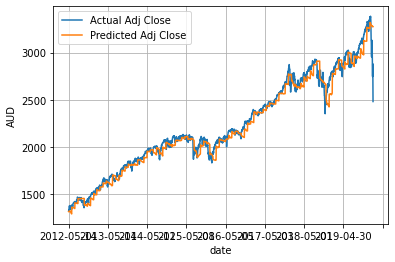

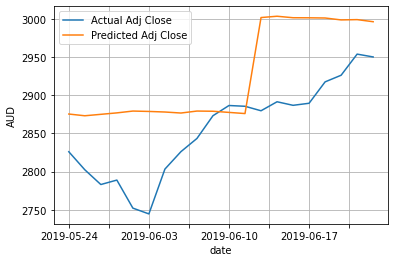

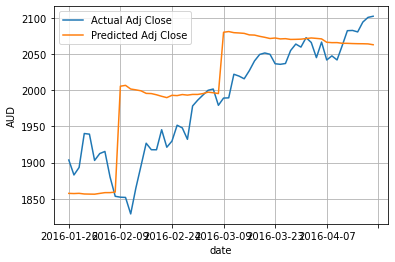

In [0]:
# Cross Validation
train_cv = dataset[train_cut - lags:][include]
val_adj = train_cv[features]
# scalers_cv = [MinMaxScaler() for a in range(len(features))]
# for a, feature in zip(range(len(features)), features):
#   val_adj.loc[:, feature] = scalers_cv[a].fit_transform(np.array(train_cv[feature]).reshape(-1,1))
  # val_adj.loc[:, feature] = scale(np.array(train_cv[feature]).reshape(-1,1))
# val_adj = close_scaler.transform(np.array(train_cv['Adj Close']).reshape(-1,1))
# val_adj = np.concatenate((val_adj,volume_scaler.transform(np.array(train_cv['Volume']).reshape(-1,1))),axis=1)
# print(val_adj)
cv_x, cv_y = get_xy(np.array(val_adj), lags, forecasts)
# print(val_adj)

# alternative scaling attempt. scalar didn't fit though
# scalers_cv = [MinMaxScaler() for a in range(len(features))]
# for a, feature in zip(range(len(features)), features):
#   cv_x[:, :, a] = scalers_cv[a].fit_transform(cv_x[:, :, a])


# print(cv_y)
# cv_x = scaler.fit_transform(np.array(cv_x))
# print(scaler.mean_)
# scaler = StandardScaler()
# scaler = MinMaxScaler()
# cv_x = scaler.transform(cv_x)
# cvscaler = MinMaxScaler()
# print(np.array(val_adj['Adj Close']).shape)
# cvscaler.fit(np.array(np.array(val_adj['Adj Close']).reshape(-1,1)))
cv_x = cv_x.reshape(cv_x.shape[0], cv_x.shape[1], feature_sets)
all_preds = []
for a in range(0, len(cv_x), forecasts):
  cv_scalers = [MinMaxScaler() for a in range(feature_sets)]
  cv_xa = cv_x[a]
  # print(cv_xa.shape)
  for feature_num in range(feature_sets):
    cv_xa[:,feature_num] = cv_scalers[feature_num].fit_transform(np.array(cv_xa[:, feature_num]).reshape(-1,1)).reshape(-1)
  # preds = model.predict(cv_features.reshape(1,-1,feature_sets), verbose=0)
  # cv_xa[:,0] = cvscaler.transform(cv_xa[:,0].reshape(-1,1)).reshape(-1)
  preds = model.predict(cv_xa.reshape(1, -1, feature_sets))
  # print(preds.shape)
  preds = cv_scalers[0].inverse_transform(preds)
  # preds = cvscaler.inverse_transform(preds)
  # print(preds)
  all_preds.extend(preds.flatten())
  # print(preds.shape)
all_preds = np.array(all_preds)
# print(all_preds)
# cv_x = cv_x[0]
cv_y = cv_y.reshape(cv_y.shape[0], -1)
# preds = model.predict(cv_x.reshape(1, -1, 1), verbose=1)
# preds = model.predict(cv_x, verbose=1)
# print(preds)
# mape = get_mape(cv_y[0].reshape(1, -1), preds)
mape = get_mape(np.array(val_adj['Adj Close']).reshape(-1)[lags:len(all_preds)+lags], all_preds)
# # print(cv_y[0])
# mape = get_mape()
print('MAPE: {}'.format(mape))
print(cv_x.shape)
print(cv_y.shape)
print(val_adj.shape)
print(all_preds.shape)
# preds_graph = pd.DataFrame({'Adj Close': preds.reshape(-1), 'Date': val['Date'][0:forecasts]})
# graph = val[0:forecasts].plot(x='Date', y='Adj Close', grid=True)
preds_graph = pd.DataFrame({'Predicted Adj Close': all_preds.reshape(-1), 'Date': train_cv['Date'][0:len(all_preds)]})
test_cv_y = pd.DataFrame({'Actual Adj Close': np.array(val_adj['Adj Close']).reshape(-1)[lags:len(all_preds)+lags], 'Date': train_cv['Date'][lags:len(all_preds)+lags]})
# preds_graph = pd.DataFrame({'Adj Close': preds.reshape(-1), 'Date': val['Date'][0:forecasts]})
# test_cv_y = pd.DataFrame({'Adj Close': cv_y.reshape(-1)[0:forecasts], 'Date': val['Date'][0:forecasts]})
# graph = val[0:-1].plot(x='Date', y='Adj Close', grid=True)
graph = test_cv_y.plot(x='Date', y='Actual Adj Close', grid=True)
graph = preds_graph.plot(x='Date', y="Predicted Adj Close", ax=graph, grid=True)
graph.set_xlabel('date')
graph.set_ylabel('AUD')
# one forecast version
import random
index = random.randint(0,len(cv_x)-forecasts)
# preds = model.predict(cv_x[index].reshape(1,-1,feature_sets))
# print("ASD:" preds.shape)
preds_graph = pd.DataFrame({'Predicted Adj Close': all_preds[index:index+forecasts], 'Date': train_cv['Date'][index:index+forecasts]})
test_cv_y = pd.DataFrame({'Actual Adj Close': np.array(val_adj['Adj Close']).reshape(-1)[index:index+forecasts], 'Date': train_cv['Date'][index:index+forecasts]})
graph = test_cv_y.plot(x='Date', y='Actual Adj Close', grid=True)
graph = preds_graph.plot(x='Date', y="Predicted Adj Close", ax=graph, grid=True)
graph.set_xlabel('date')
graph.set_ylabel('AUD')

multi_day = 3*forecasts
index = random.randint(0,len(cv_x)-multi_day)
preds_graph = pd.DataFrame({'Predicted Adj Close': all_preds.reshape(-1)[index:index+multi_day], 'Date': train_cv['Date'][index:index+multi_day]})
test_cv_y = pd.DataFrame({'Actual Adj Close': np.array(val_adj['Adj Close']).reshape(-1)[index:index+multi_day], 'Date': train_cv['Date'][index:index+multi_day]})
# preds_graph = pd.DataFrame({'Adj Close': preds.reshape(-1), 'Date': val['Date'][0:forecasts]})
# test_cv_y = pd.DataFrame({'Adj Close': cv_y.reshape(-1)[0:forecasts], 'Date': val['Date'][0:forecasts]})
# graph = val[0:-1].plot(x='Date', y='Adj Close', grid=True)
graph = test_cv_y.plot(x='Date', y='Actual Adj Close', grid=True)
graph = preds_graph.plot(x='Date', y="Predicted Adj Close", ax=graph, grid=True)
graph.set_xlabel('date')
graph.set_ylabel('AUD')
# 1.3467608392702086
# 1.4313663148122597
#2.6

In [0]:
final_test = dataset[val_cut - lags:][['Date', 'Adj Close', 'Volume', 'Diff']]
test_adj = final_test[['Adj Close','Volume']]
test_adj = close_scaler.transform(np.array(final_test['Adj Close']).reshape(-1,1))
test_adj = np.concatenate((test_adj,volume_scaler.transform(np.array(final_test['Volume']).reshape(-1,1))),axis=1)
test_x, test_y = get_xy(np.array(test_adj), lags, forecasts)
# test_x = scaler.transform(test_x)
test_x = test_x.reshape(test_x.shape[0], test_x.shape[1], 2)
# day = 500
test_y = test_y.reshape(test_y.shape[0], -1)
# test_x = test_x[day]
all_test_preds = []
for a in range(0, len(test_x), forecasts):
  preds = model.predict(test_x[a].reshape(1,-1,2), verbose=0)
  all_test_preds.extend(preds.flatten())
  # print(preds.shape)
all_test_preds = np.array(all_test_preds)
print(test_adj.shape)
print(test_x.shape)
print(test_y.shape)
# test_preds = model.predict(test_x.reshape(1, test_x.shape[0], 1))
# test_preds = model.predict(test_x)
print(all_test_preds.shape)
test_mape = get_mape(test_adj[:,0][lags:len(all_test_preds)+lags], all_test_preds)
print("MAPE: {}".format(test_mape))
# test_graph = pd.DataFrame({'Adj Close': test_preds.reshape(-1), 'Date': test['Date'][0:forecasts]})
# t_graph = test[0:forecasts].plot(x='Date', y='Adj Close', grid=True)
# test_graph = pd.DataFrame({'Adj Close': test_preds.reshape(-1), 'Date': test['Date'][0:-1]})
# t_graph = test[0:-1].plot(x='Date', y='Adj Close', grid=True)
# test_test_y = pd.DataFrame({'Adj Close': test_y.reshape(-1)[day:day+forecasts], 'Date': test['Date'][day:day+forecasts]})

test_preds_graph = pd.DataFrame({'Predicted Adj Close': all_test_preds.reshape(-1), 'Date': final_test['Date'][lags:len(all_test_preds)+lags]})
test_test_y = pd.DataFrame({'Actual Adj Close': test_adj[:,0][lags:len(all_test_preds)+lags], 'Date': final_test['Date'][lags:len(all_test_preds)+lags]})
# preds_graph = pd.DataFrame({'Adj Close': preds.reshape(-1), 'Date': val['Date'][0:forecasts]})
# test_cv_y = pd.DataFrame({'Adj Close': cv_y.reshape(-1)[0:forecasts], 'Date': val['Date'][0:forecasts]})
# graph = dataset[val_cut - lags:][['Date', 'Adj Close']][0:-1].plot(x='Date', y='Adj Close', grid=True)
t_graph = test_test_y.plot(x='Date', y='Actual Adj Close', grid=True)
test_preds_graph.plot(x='Date', y='Predicted Adj Close', grid=True, ax=t_graph)
t_graph.set_xlabel('Date')
t_graph.set_ylabel('AUD')

index = random.randint(0,len(test_x))
preds = model.predict(test_x[index].reshape(1,-1,2))
preds_graph = pd.DataFrame({'Predicted Adj Close': preds.reshape(-1), 'Date': final_test['Date'][0:forecasts]})
test_cv_y = pd.DataFrame({'Actual Adj Close': test_y.reshape(-1)[index:index+forecasts], 'Date': final_test['Date'][index:index+forecasts]})
graph = test_cv_y.plot(x='Date', y='Actual Adj Close', grid=True)
graph = preds_graph.plot(x='Date', y="Predicted Adj Close", ax=graph, grid=True)
graph.set_xlabel('date')
graph.set_ylabel('AUD')

multi_day = 3*forecasts
index = random.randint(0,len(cv_x)-multi_day)
preds_graph = pd.DataFrame({'Predicted Adj Close': all_test_preds.reshape(-1)[0:multi_day], 'Date': final_test['Date'][0:len(all_test_preds[0:multi_day])]})
test_cv_y = pd.DataFrame({'Actual Adj Close': test_adj.reshape(-1)[lags:len(all_test_preds[0:multi_day])+lags], 'Date': final_test['Date'][lags:len(all_test_preds[0:multi_day])+lags]})
# preds_graph = pd.DataFrame({'Adj Close': preds.reshape(-1), 'Date': val['Date'][0:forecasts]})
# test_cv_y = pd.DataFrame({'Adj Close': cv_y.reshape(-1)[0:forecasts], 'Date': val['Date'][0:forecasts]})
# graph = val[0:-1].plot(x='Date', y='Adj Close', grid=True)
graph = test_cv_y.plot(x='Date', y='Actual Adj Close', grid=True)
graph = preds_graph.plot(x='Date', y="Predicted Adj Close", ax=graph, grid=True)
graph.set_xlabel('date')
graph.set_ylabel('AUD')

KeyError: ignored

In [0]:
# Saving the model so it can be used in our web app
model.save('/content/model_3.h5')
# !zip -r /content/model.zip /content/model

In [0]:
new_model = tf.keras.models.load_model('/content/model')

In [0]:
new_model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 200, 250)          263000    
_________________________________________________________________
lstm_7 (LSTM)                (None, 200, 100)          140400    
_________________________________________________________________
lstm_8 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_115 (Dense)            (None, 128)               12928     
_________________________________________________________________
dense_116 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_117 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_118 (Dense)            (None, 64)              